<a href="https://colab.research.google.com/github/ssriram1978/car_speed_detector/blob/master/HuggingPics_Car_classifier_with_confusion_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingPics 🤗🖼️

Fine-tune Vision Transformers for **anything** using images found on the web.

In [ ]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [ ]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

## Defining your search terms

Simply replace the terms in the widget below with whatever you want to classify, and we'll download ~150 images for each class for you.

You can define up to 5 classes. For < 5 classes, just leave the remaining text boxes blank.

### Examples

💡 If you need some inspiration, take a look at these examples:

|            | [nateraw/rare-puppers](https://huggingface.co/nateraw/rare-puppers) | [nateraw/pasta-pizza-ravioli](https://huggingface.co/nateraw/pasta-pizza-ravioli) | [nateraw/baseball-stadium-foods](https://huggingface.co/nateraw/baseball-stadium-foods) | [nateraw/denver-nyc-paris](https://huggingface.co/nateraw/denver-nyc-paris) |
| ---------- | ------------------------------------------------------------------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| **term_1** | samoyed                                                             | pizza                                                                             | cotton candy                                                                            | denver                                                                      |
| **term_2** | shiba inu                                                           | pasta                                                                             | hamburger                                                                               | new york city                                                               |
| **term_3** | corgi                                                               | ravioli                                                                           | hot dog                                                                                 | paris                                                                       |
| **term_4** |                                                                     |                                                                                   | nachos                                                                                  |                                                                             |
| **term_5** |                                                                     |                                                                                   | popcorn                                                                                 |                                                                             |



In [ ]:
term_1 = "samoyed" #@param {type:"string"}
term_2 = "shiba inu" #@param {type:"string"}
term_3 = "corgi" #@param {type:"string"}
term_4 = "" #@param {type:"string"}
term_5 = "" #@param {type:"string"}

search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4,
    term_5
])

search_terms = [x for x in search_terms if x.strip() != '']

## Get Images From The Web

Here, we loop over your selected search terms and collect ~150 related images for each.

We'll save them to a new folder named `images/` that is structured to work with [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder).

In [ ]:
SEARCH_URL = "https://huggingface.co/api/experimental/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

In [ ]:
# data_dir = Path('images')

# if data_dir.exists():
#     shutil.rmtree(data_dir)

# for search_term in search_terms:
#     search_term_dir = data_dir / search_term
#     search_term_dir.mkdir(exist_ok=True, parents=True)
#     urls = get_image_urls_by_term(search_term)
#     print(f"Saving images of {search_term} to {str(search_term_dir)}...")
#     urls_to_image_folder(urls, search_term_dir)

## Init Dataset and Split into Training and Validation Sets


Import torch, matplotlib, numpy and torchvision.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
import os
import requests
import shutil
from torchvision import datasets, transforms, models
from pathlib import Path
import tarfile
import scipy.io
import cv2 as cv
import random
import re
import csv

Set the device type variable to cuda or cpu.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')

device = cuda:0


Get the Training, Validation & Testing dataset.

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

In [ ]:
def download_tar_gz_files(url, destination_path, destination_tar_file_name='downloaded_file.tgz'):
  # Delete the destination path if it already exist in the current environment.
  if os.path.exists(destination_path):
    shutil.rmtree(destination_path)
  
  # Create a new destination directory path.
  os.mkdir(destination_path)
  
  # Download the url to the destination - downloaded_file.tgz.
  response = requests.get(url, stream=True)
  if response.status_code == 200:
    with open(os.path.join(destination_path, destination_tar_file_name), 'wb') as f:
      f.write(response.raw.read())

  # Untar the downloaded file to the destination path.
  tar_file = tarfile.open(os.path.join(destination_path, destination_tar_file_name))
  tar_file.extractall(destination_path) # specify which folder to extract to
  tar_file.close()

  # Print the total number of files in the tar file.
  print(destination_path)
  pathlist = destination_path.glob('**/*.jpg')
  image_path_list = []
  for path in pathlist:
    image_path_list.append(str(path))
  print(f"There are {len(image_path_list)} images in this path.")  

Download training data - http://imagenet.stanford.edu/internal/car196/cars_train.tgz

In [ ]:
training_url = 'http://ai.stanford.edu/~jkrause/car196/cars_train.tgz'
cars_training_path = Path('./cars_training') # Create a path object and pass in the name of the directory ("cars_training") where you will be downloading the dataset.
download_tar_gz_files(training_url, cars_training_path)
cars_training_path = Path('./cars_training/cars_train') # set the cars training path to the inner sub directory.

cars_training
There are 8144 images in this path.


Download testing data - http://imagenet.stanford.edu/internal/car196/cars_test.tgz

In [ ]:
testing_url = 'http://ai.stanford.edu/~jkrause/car196/cars_test.tgz'
cars_testing_path = Path('./cars_testing')
download_tar_gz_files(testing_url, cars_testing_path)
cars_testing_path = Path('./cars_testing/cars_test')

cars_testing
There are 8041 images in this path.


A devkit, including class labels for training images and bounding boxes for all images, can be downloaded here - http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

In [ ]:
annotations_url = 'http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz'
cars_annotations_path = Path('./cars_annotations')
download_tar_gz_files(annotations_url, cars_annotations_path)

cars_annotations
There are 0 images in this path.


Download test annotations with labels - http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat



In [ ]:
annotations_test_url = 'http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat'
cars_test_annotations_path = Path('./cars_annotations/devkit/cars_test_annos_withlabels.mat')
# Download the url to the destination - downloaded_file.tgz.
response = requests.get(annotations_test_url, stream=True)
if response.status_code == 200:
  with open(cars_test_annotations_path, 'wb') as f:
    f.write(response.raw.read())

Save the annotations to variables.

In [ ]:
cars_test_annos = 'cars_annotations/devkit/cars_test_annos_withlabels.mat'
car_train_annos = 'cars_annotations/devkit/cars_train_annos.mat'
car_meta_annos = 'cars_annotations/devkit/cars_meta.mat'

Install console progress bar to observe the progression of preparing training and testing data based upon the annotations.

In [ ]:
!pip install console_progressbar
from console_progressbar import ProgressBar

  Created wheel for console-progressbar: filename=console_progressbar-1.1.2-py3-none-any.whl size=4156 sha256=7f4d0165b9987d8d6602b73b7b39680cff18e4c4085b47b86ad04ce88e38c96f
  Stored in directory: /root/.cache/pip/wheels/2b/5f/7d/97976c8b046302df5781c0cbb18fd04b9d58467edae9942bfa
Successfully built console-progressbar


Load the class name into a list. Sanitize the class names by replacing whitespaces with _ which will be used to create sub directories under test and train output. Example: "Ram C/V Cargo Van Minivan 2012" -> Ram_C_V_Cargo_Van_Minivan_2012

Use scipy.io.loadmat to load the annotations which is in .mat format. Get all the cars_name_list by replacing white spaces with '_' symbol.

In [ ]:
cars_name_list = []
print(f"Processing annotations metadata {car_meta_annos}")
cars_meta = scipy.io.loadmat(car_meta_annos)
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print(f'type of class_names = {type(class_names)}')
print(f'size of class_names = {class_names.size}')
for index in range(class_names.size):
  # Replace white space and / with _. Example: "Ram C/V Cargo Van Minivan 2012" -> Ram_C_V_Cargo_Van_Minivan_2012
  cars_name_list.append(re.sub(r"(/|\s+)", r'_', class_names[index][0][0]))

print('length of cars_name_list = {}, Sample class_name: [{}]'.format(len(cars_name_list), cars_name_list[3]))

Processing annotations metadata cars_annotations/devkit/cars_meta.mat
class_names.shape: (196, 1)
type of class_names = <class 'numpy.ndarray'>
size of class_names = 196
length of cars_name_list = 196, Sample class_name: [Acura_TL_Type-S_2008]


For each of the class name, create a sub directory in cars_testing_output directory and cars_training_output directory.

In [ ]:
cars_training_output_path = Path('./cars_training_output')
cars_testing_output_path = Path('./cars_testing_output')

Process the train data and classify them into the cars_testing_output and cars_training_output directory with the correct class name as the sub directory name.

In [ ]:
def create_destination_directory_with_names(dest, name_list):
  # Delete the training output dir.
  if os.path.exists(dest):
    shutil.rmtree(dest)
  if not dest.exists():
      dest.mkdir()
  #Create sub directories with the name of the car names in the destination.
  print("creating sub directories in {} with names found in {}.".format(
      dest, name_list))
  for o in name_list:
    final_dest = (dest/o)
    final_dest.mkdir(exist_ok=True)


create_destination_directory_with_names(cars_training_output_path, cars_name_list)
create_destination_directory_with_names(cars_testing_output_path, cars_name_list)

creating sub directories in cars_training_output with names found in ['AM_General_Hummer_SUV_2000', 'Acura_RL_Sedan_2012', 'Acura_TL_Sedan_2012', 'Acura_TL_Type-S_2008', 'Acura_TSX_Sedan_2012', 'Acura_Integra_Type_R_2001', 'Acura_ZDX_Hatchback_2012', 'Aston_Martin_V8_Vantage_Convertible_2012', 'Aston_Martin_V8_Vantage_Coupe_2012', 'Aston_Martin_Virage_Convertible_2012', 'Aston_Martin_Virage_Coupe_2012', 'Audi_RS_4_Convertible_2008', 'Audi_A5_Coupe_2012', 'Audi_TTS_Coupe_2012', 'Audi_R8_Coupe_2012', 'Audi_V8_Sedan_1994', 'Audi_100_Sedan_1994', 'Audi_100_Wagon_1994', 'Audi_TT_Hatchback_2011', 'Audi_S6_Sedan_2011', 'Audi_S5_Convertible_2012', 'Audi_S5_Coupe_2012', 'Audi_S4_Sedan_2012', 'Audi_S4_Sedan_2007', 'Audi_TT_RS_Coupe_2012', 'BMW_ActiveHybrid_5_Sedan_2012', 'BMW_1_Series_Convertible_2012', 'BMW_1_Series_Coupe_2012', 'BMW_3_Series_Sedan_2012', 'BMW_3_Series_Wagon_2012', 'BMW_6_Series_Convertible_2007', 'BMW_X5_SUV_2007', 'BMW_X6_SUV_2012', 'BMW_M3_Coupe_2012', 'BMW_M5_Sedan_2010', '

Organize training and testing data into sub-folders containing the class name as the sub-folder name based on the annotations bounding box.

In [ ]:
img_width, img_height = 224, 224

def save_data_into_directory_based_on_bounding_box(fnames, labels, bboxes, src_folder, dst_folder, csv_file_name = None):
    num_samples = len(fnames)
    pb = ProgressBar(total=100, prefix='Saving data', suffix='', decimals=3, length=50, fill='=')
    writer = None
    if csv_file_name:
      fp = open(csv_file_name, 'a', newline='')
      fieldnames = ['file_name', 'label']
      writer = csv.DictWriter(fp, fieldnames=fieldnames)
      writer.writeheader()

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
        if writer:
          writer.writerow({'file_name': dst_path, 'label': label})

Process Data

In [ ]:
def get_bboxes_classid_fname_labels_from_annotations(car_annotation_path):
    print(f"Processing data {car_annotation_path}.")
    cars_annos = scipy.io.loadmat(car_annotation_path)
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append(cars_name_list[class_id-1])
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)
    return bboxes, class_ids, fnames, labels

Invoke the above defined functions for training data.

In [ ]:
training_labels = []
if not len(training_labels):
  bboxes, training_class_ids, training_fnames, training_labels = get_bboxes_classid_fname_labels_from_annotations(car_train_annos)
  save_data_into_directory_based_on_bounding_box(training_fnames, training_labels, bboxes, src_folder = (cars_training_path),
                                               dst_folder = cars_training_output_path)
  training_labels_count=len(np.unique(training_labels))


Processing data cars_annotations/devkit/cars_train_annos.mat.
Saving data |==================================================| 100.000% 


Invoke the above defined functions for testing data.

Print the total number of downloaded cars training files.

In [ ]:
pathlist = cars_training_output_path.glob('**/*.jpg')
image_path_list = []
for path in pathlist:
  image_path_list.append(str(path))
print(f"There are {len(image_path_list)} images in this path.") 

There are 8144 images in this path.


Print the training class ids, training labels, training_fnames and the total number of unique cars used for training.

In [ ]:
print("training_class_ids = {}.".format(np.unique(training_class_ids)))
print("training_labels = {}.".format(np.unique(training_labels)))
print("training_fnames = {}.".format(training_fnames))
print('The number of different cars = {}'.format(training_labels_count))

training_class_ids = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196].
training_labels = ['AM_General_Hummer_SUV_2000' 'Acura_Integra_Type_R_2001'
 'Acura_RL_Sedan_2012' 'Acura_TL_Sedan_2012' 'Acura_TL_Type-S_2008'
 'Acura_TSX_Sedan_2012' 'Acura_ZDX_Hat

Invoke the above defined functions for testing data.

Print the total number of downloaded cars testing files.

Print the testing class ids, testing labels, testing_fnames and the total number of unique cars used for testing.

In [ ]:
testing_labels = []
if not len(testing_labels):
  testing_bboxes, testing_class_ids, testing_fnames, testing_labels = get_bboxes_classid_fname_labels_from_annotations(cars_test_annos)
  save_data_into_directory_based_on_bounding_box(testing_fnames, testing_labels, testing_bboxes, src_folder = (cars_testing_path),
                                               dst_folder = cars_testing_output_path,
                                               csv_file_name = 'testing_data.csv')
  testing_labels_count=len(np.unique(testing_labels))

pathlist = cars_testing_output_path.glob('**/*.jpg')
image_path_list = []
for path in pathlist:
  image_path_list.append(str(path))
print(f"There are {len(image_path_list)} images in this path.") 

print("testing_class_ids = {}.".format(np.unique(testing_class_ids)))
print("testing_labels = {}.".format(np.unique(testing_labels)))
print("testing_fnames = {}.".format(testing_fnames))
print('The number of different cars = {}'.format(testing_labels_count))


Processing data cars_annotations/devkit/cars_test_annos_withlabels.mat.
Saving data |==================================================| 100.000% 
There are 8041 images in this path.
testing_class_ids = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196].


In [ ]:
ds = ImageFolder(cars_training_output_path)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Show Some Examples

#### ⚠️ Note - The image search API isn't perfect ⚠️

You may need to go back, tweak your search terms, and repeat the cells above until the images shown below look good.

A few bad images is OK, but if they are completely incorrect, you'll definitely want to try again with different terms.

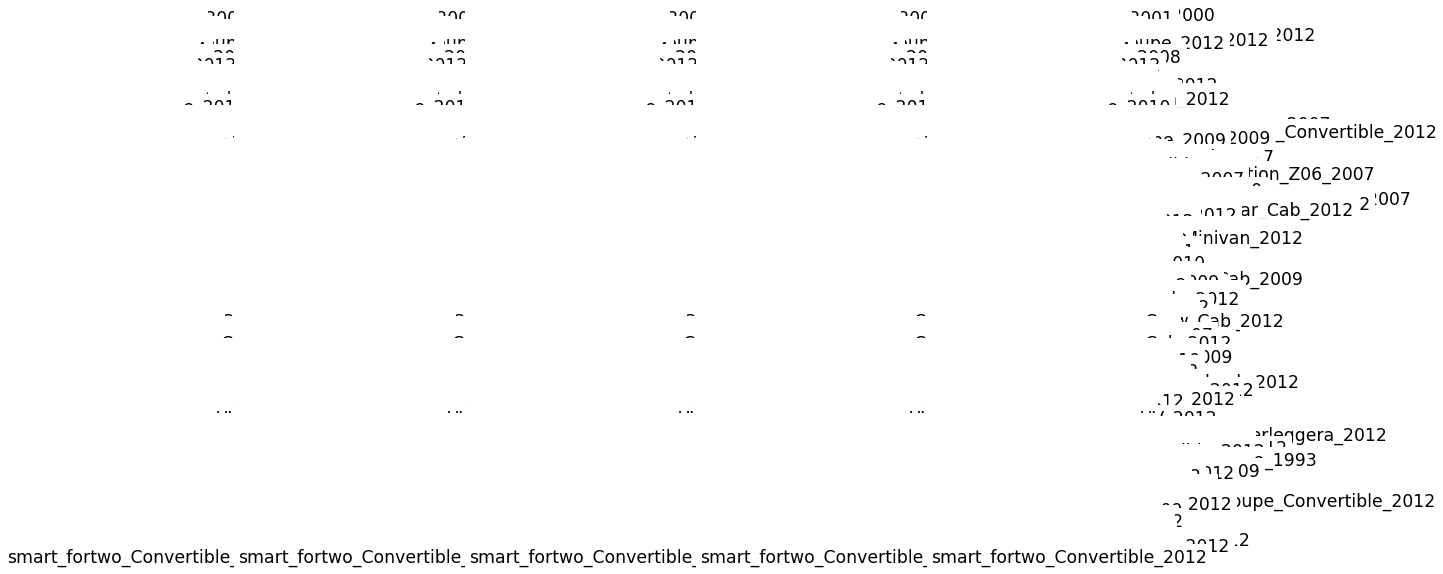

In [ ]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [ ]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name
print(f'len(label2id)={len(label2id)}, len(id2label) = {len(id2label)}') 

len(label2id)=196, len(id2label) = 196


## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

## Init Feature Extractor, Model, Data Loaders


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [ ]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=8)
trainer.fit(classifier, train_loader, val_loader)

Global seed set to 42
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.9 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.9 M    Trainable params
0         Non-trainable params
85.9 M    Total params
171.899   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Check if it Worked 😅

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([ 93, 186,  26,  15,  45, 102, 134, 108])
Labels: tensor([ 93,  49,  26, 156,  45, 102, 134, 108])


Validate the test output directory.

In [ ]:
def find_mismatch(preds, original_labels, mismatch_output_list, mismatch_dict):
  for pred, label in zip(preds, original_labels):
    if pred != label:
      mismatch_dict[label].append(pred)
      mismatch_output_list.append([label, pred])
  return mismatch_output_list, mismatch_dict


In [ ]:
from collections import defaultdict

validation_ds = ImageFolder(cars_testing_output_path)
val_ds = torch.utils.data.Subset(ds, indices[:])
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)
val_batch = next(iter(val_loader))
mismatch_output_list = []
mismatch_dict = defaultdict(list)
y_true = []
y_pred = []

for val_batch in val_loader:
  outputs = model(**val_batch)
  preds = outputs.logits.softmax(1).argmax(1)
  original_labels = val_batch['labels']
  y_true += original_labels
  y_pred += preds
  find_mismatch(preds, original_labels, mismatch_output_list, mismatch_dict)
  #print('Preds: ', outputs.logits.softmax(1).argmax(1))
  #print('Labels:', val_batch['labels'])

print(f'len(mismatch_output_list)={len(mismatch_output_list)}')


len(mismatch_output_list)=225


Display Confusion Matrix and Classification Report

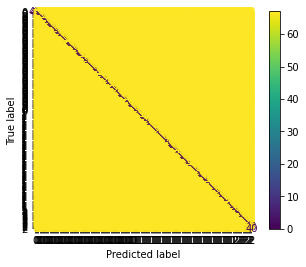

<Figure size 86400x86400 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        45
           2       0.93      0.81      0.87        32
           3       0.93      0.98      0.95        43
           4       0.95      0.98      0.96        42
           5       0.93      0.90      0.91        41
           6       0.97      0.97      0.97        39
           7       0.90      1.00      0.95        45
           8       0.95      1.00      0.98        41
           9       1.00      0.88      0.94        33
          10       1.00      0.97      0.99        38
          11       0.97      0.93      0.95        41
          12       1.00      0.98      0.99        43
          13       0.93      0.90      0.91        41
          14       1.00      0.98      0.99        43
          15       0.97      1.00      0.99        37
          16       0.95      0.87      0.91        45
          17       0.97    

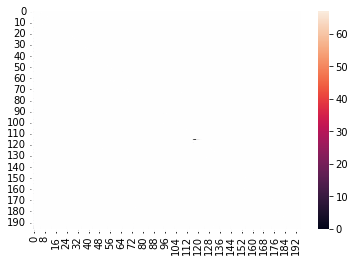

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

display = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.figure(figsize=(1200,1200))
plt.show(display.plot)
print(classification_report(y_true, y_pred))

import pandas as pd
import seaborn as sns
confusion_matrix_df = pd.DataFrame(display.confusion_matrix)
sns.heatmap(confusion_matrix_df, annot=True)

Print the model

In [ ]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

Copy/Paste a test data from the internet and check how well the model hypothesis output matches with the groundtruth data.

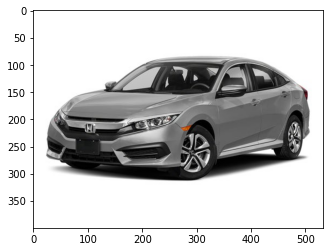

In [ ]:
import PIL.ImageOps
import requests
from PIL import Image
 
url = 'https://www.hondamarysville.com/assets/stock/colormatched_01/white/640/cc_2018hoc020013_01_640/cc_2018hoc020013_01_640_si.jpg?height=400'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

Try transforming the image.

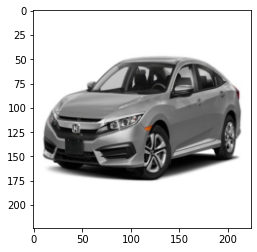

In [ ]:
# Create the validation data transform object for augmenting the image and resizing the image to fit into an existing pre-trained model.
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
# Define a function to transpose the image.
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image
  
img = transform(img) 
plt.imshow(im_convert(img))

Print the class name for the specified input test data image.

Define the classes used in feature classification.

In [ ]:
classes = [x for x in np.unique(training_labels)]
print(classes)

['AM_General_Hummer_SUV_2000', 'Acura_Integra_Type_R_2001', 'Acura_RL_Sedan_2012', 'Acura_TL_Sedan_2012', 'Acura_TL_Type-S_2008', 'Acura_TSX_Sedan_2012', 'Acura_ZDX_Hatchback_2012', 'Aston_Martin_V8_Vantage_Convertible_2012', 'Aston_Martin_V8_Vantage_Coupe_2012', 'Aston_Martin_Virage_Convertible_2012', 'Aston_Martin_Virage_Coupe_2012', 'Audi_100_Sedan_1994', 'Audi_100_Wagon_1994', 'Audi_A5_Coupe_2012', 'Audi_R8_Coupe_2012', 'Audi_RS_4_Convertible_2008', 'Audi_S4_Sedan_2007', 'Audi_S4_Sedan_2012', 'Audi_S5_Convertible_2012', 'Audi_S5_Coupe_2012', 'Audi_S6_Sedan_2011', 'Audi_TTS_Coupe_2012', 'Audi_TT_Hatchback_2011', 'Audi_TT_RS_Coupe_2012', 'Audi_V8_Sedan_1994', 'BMW_1_Series_Convertible_2012', 'BMW_1_Series_Coupe_2012', 'BMW_3_Series_Sedan_2012', 'BMW_3_Series_Wagon_2012', 'BMW_6_Series_Convertible_2007', 'BMW_ActiveHybrid_5_Sedan_2012', 'BMW_M3_Coupe_2012', 'BMW_M5_Sedan_2010', 'BMW_M6_Convertible_2010', 'BMW_X3_SUV_2012', 'BMW_X5_SUV_2007', 'BMW_X6_SUV_2012', 'BMW_Z4_Convertible_2012

In [ ]:
#image = img.to(device).unsqueeze(0)
image = img.unsqueeze(0)
output = model(image)
preds = output.logits.softmax(1).argmax(1)
for pred in preds:
  print(f'pred={pred}, original_label ={classes[pred]}')

pred=125, original_label =Honda_Accord_Coupe_2012


# Push to 🤗 Hub 🚀

You'll need to authenticate with your Hugging Face account, so make sure to [sign up](https://huggingface.co/join) if you haven't already.

Your repo will be created at `{hf_username}/{model_id}`, so pick a `model_id` you like 😊

In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
model_id = "sriram-car-classifier" #@param {type:"string"}

description = """
Autogenerated by HuggingPics🤗🖼️

Create your own image classifier for **anything** by running [the demo on Google Colab](https://colab.research.google.com/github/nateraw/huggingpics/blob/main/HuggingPics.ipynb).

Report any issues with the demo at the [github repo](https://github.com/nateraw/huggingpics).
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

# Delete model folder, as we (re)create it here.
if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, name=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )


# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")

Cloning https://huggingface.co/SriramSridhar78/sriram-car-classifier into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.37k/328M [00:00<?, ?B/s]

Upload file runs/events.out.tfevents.1643155175.9e55c25f7eba.74.0:  24%|##4       | 3.38k/13.9k [00:00<?, ?B/s…

To https://huggingface.co/SriramSridhar78/sriram-car-classifier
   bea5aba..b979732  main -> main



Check out your model at:
https://huggingface.co/SriramSridhar78/sriram-car-classifier
